In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from collections import Counter

In [2]:
import statsmodels.api as sm
# from statsmodels.discrete.discrete_model import Logit
# from statsmodels.discrete.discrete_model import LogitResults
from sklearn.model_selection import train_test_split # X, y, random_state=9
from sklearn.preprocessing import StandardScaler # .fit(X_train), .transform(X) & y

from sklearn.metrics import accuracy_score # (y_test, y_pred)
from sklearn.metrics import classification_report # (y_test, y_pred)
from sklearn.metrics import confusion_matrix # (y_test, y_pred)

In [3]:
dfmodel = pd.read_pickle('../../data/ecommerce/dfmodel_script.pkl', compression='zip')

In [12]:
dfmodel.head(3)
# dfmodel.shape

,timestamp,product_count,transactionid,addtocart,transaction,view,time_delta,time_hour,made_purchase
visitorid,,,,,,,,,
0,2015-09-11 14:55:17,3,NaN,0,0,3,00:05:28,0.091111,0
2,2015-08-07 12:20:57,4,NaN,0,0,8,00:29:13,0.486944,0
6,2015-08-30 21:21:25,3,NaN,1,0,5,21:17:37,21.293611,0


In [5]:
df20 = dfmodel.sample(20000, random_state=46)
df20.head()
df20[df20['transaction'] > 0].shape

(623, 9)

In [10]:
col_all = ['product_count', 'addtocart', 'view', 'time_hour']

In [7]:
def sort_split(df):
    """ return holdout, crossval, tank
    data randomly split among groups for modelling
    2x upsample 11449 purchase rows
    380127 rows main dfmodel
    """
    intforrand = 9
    purmask = df['made_purchase'] == 1
    pur = df[purmask]
    nopur = df[~purmask]
    pur = pur.sample(frac=2., replace=True, random_state=intforrand) # upsample to 22898
    upsamp_rows_size = pur.shape[0]
    # split pur
    holdpur = pur.sample(frac=0.25, random_state=intforrand) #df
    holdmask = pur.index.isin(holdpur.index)
    crosspur = pur[~holdmask] #df
    # split nopur
    times4_size = upsamp_rows_size * 4
    nopur_formodel = nopur.sample(n=times4_size, random_state=intforrand) #  91592
    holdnopur = nopur_formodel.sample(frac=0.25, random_state=intforrand) #df
    holdmaskno = nopur_formodel.index.isin(holdpur.index)
    crossnopur = nopur_formodel[~holdmaskno]  #df
    # set aside tank data unused for model
    tankmask = nopur.index.isin(nopur_formodel.index)
    dftank = nopur[~tankmask]  #df
    # combine for crossval and holdout
    holdappended = holdnopur.append(holdpur)
    crossappended = crossnopur.append(crosspur)
    holdout = holdappended.sample(frac=1., random_state=intforrand)
    crossval = crossappended.sample(frac=1., random_state=intforrand)
    return holdout, crossval, dftank

In [4]:
purmask = dfmodel['made_purchase'] == 1
pur = dfmodel[purmask]
print(dfmodel[~purmask].shape)
print(pur.shape)
print(dfmodel.shape)

(368678, 9)
(11449, 9)
(380127, 9)


In [35]:
testq = pur.sample(frac=0.25, random_state=9)
pur.sample(frac=1., replace=False, random_state=9).shape

(11449, 9)

In [31]:
mask = pur.index.isin(testq.index)
mask.shape

(11449,)

In [33]:
pur[~mask].shape

(8587, 9)

In [8]:
holdout20, crossval20, tank20 = sort_split(df20)
print(holdout20.shape, crossval20.shape, tank20.shape)

(1558, 9) (5540, 9) (14393, 9)


In [11]:
# sm.Logit()
# sm.add_constant()
X20 = crossval20[col_all].to_numpy()
y20 = crossval20['made_purchase'].to_numpy().reshape(-1,1)
print(X20.shape, y20.shape)

(5540, 4) (5540, 1)


In [59]:
# crossval20[col_all].head().to_numpy()
crossval20[col_all].head(2)
# crossval20['made_purchase'].head()

,product_count,addtocart,view,time_hour
visitorid,,,,
1340751,1,0,2,120.808889
1062248,4,0,4,0.080278


In [12]:
# STANDARDIZE
scaler = StandardScaler().fit(X20)
X20stan = scaler.transform(X20)

In [52]:
X20 = sm.add_constant(X20)
logit20 = sm.Logit(y20, X20) # endog, exog

Logit.fit(start_params=None, method='newton', maxiter=35, full_output=1, disp=1, callback=None, **kwargs)  
https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit.html#statsmodels.discrete.discrete_model.Logit.fit

In [ ]:
logit20_res = logit20.fit()

In [ ]:
print('Parameters: ', logit20_res.params)
print(logit20_res.summary2())

In [ ]:
logit20.loglikeobs(logit20_res.params)[:50]

In [13]:
# X20stan = sm.add_constant(X20stan)
logit20stan = sm.Logit(y20, X20stan) # endog, exog
logit20stan_res = logit20stan.fit()

Optimization terminated successfully.
         Current function value: 146.064159
         Iterations 7


In [14]:
print('Parameters: ', np.exp(logit20stan_res.params))
print(logit20stan_res.summary2())

Parameters:  [ 0.83955311 17.84268107  1.40044474  1.00703565]
                          Results: Logit
Model:              Logit            Pseudo R-squared: inf         
Dependent Variable: y                AIC:              1618398.8768
Date:               2020-02-07 02:42 BIC:              1618425.3558
No. Observations:   5540             Log-Likelihood:   -8.0920e+05 
Df Model:           3                LL-Null:          0.0000      
Df Residuals:       5536             LLR p-value:      1.0000      
Converged:          1.0000           Scale:            1.0000      
No. Iterations:     7.0000                                         
----------------------------------------------------------------------
          Coef.     Std.Err.       z       P>|z|      [0.025    0.975]
----------------------------------------------------------------------
x1       -0.1749      0.1707    -1.0244    0.3056    -0.5095    0.1597
x2        2.8816      0.1058    27.2280    0.0000     2.6742    3.08

/home/scorpio/enter/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/scorpio/enter/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/scorpio/enter/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3390: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


In [166]:
logit20stan.loglikeobs(logit20stan_res.params)[:50]
# exact same as unscaled

array([-1.78336072e+02, -1.79861965e+02, -1.84458708e+02, -1.74007403e+02,
        0.00000000e+00, -1.27194286e-01, -1.79861273e+02, -1.84458755e+02,
       -1.76339355e+02, -1.84458551e+02, -1.40756435e-01, -1.78760354e+02,
       -1.71474411e+02, -1.84458585e+02, -3.10319503e+01, -1.64961449e+02,
        0.00000000e+00, -1.78760502e+02, -1.37567141e+02, -1.47892445e-01,
       -1.78760496e+02, -1.75670623e+02, -1.84119730e+02, -3.39169571e-05,
       -1.45020742e-01, -1.84458741e+02, -1.49306122e+02, -1.68458438e+02,
       -4.01990304e-07, -1.78755682e+02, -1.78760481e+02, -1.84275451e+02,
       -1.65451780e+02, -1.76462108e+02, -1.84458793e+02, -1.67758046e+02,
       -1.78760466e+02, -1.71865242e+02, -1.84458767e+02,  0.00000000e+00,
       -1.79205880e+02, -1.84458802e+02, -1.75850955e+02, -1.09844350e-02,
       -1.84458574e+02, -1.80907150e+02, -1.55872187e+02,  0.00000000e+00,
       -1.61471733e+02, -1.76461859e+02])

In [138]:
X20stan[:20, 3]

array([-0.1736138 , -0.41086118, -0.41095725, -0.32346313, -0.41092668,
        2.93823953, -0.41047416, -0.41098346,  0.27395705, -0.41086937,
       -0.31538153, -0.41093324,  2.37888283, -0.41088847, -0.35208251,
        0.26348837,  2.74192471, -0.41101621, -0.40328015,  0.38608135])

In [15]:
X20stan_prob = logit20stan_res.predict(X20stan)
X20stan_prob[:10]

array([0.33195477, 0.33062912, 0.32665187, 0.33572988, 0.99909036,
       0.88056258, 0.33062972, 0.32665183, 0.3336935 , 0.32665201])

In [140]:
X20stan[4:6] # cust with interesting numbers

array([[ 0.12535505,  2.46381328, -0.21778814, -0.41092668],
       [ 0.50868551,  0.66628571,  0.43399641,  2.93823953]])

In [30]:
print(X20stan_prob.shape)
X20stan_pred = np.uint8(X20stan_prob.reshape(-1,1) > 0.5)
# X20stan_prob.reshape(-1,1) == 1

(5540,)


In [31]:
accuracy_score(y20, X20stan_pred) # y_test, y_pred

0.9283393501805054

In [32]:
print(y20.shape, X20stan_pred.shape)
print(Counter(y20[:, 0]), Counter(X20stan_pred[:, 0]))

(5540, 1) (5540, 1)
Counter({0: 4984, 1: 556}) Counter({0: 4689, 1: 851})


In [19]:
print(classification_report(y20, X20stan_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      4984
           1       0.59      0.91      0.72       556

    accuracy                           0.93      5540
   macro avg       0.79      0.92      0.84      5540
weighted avg       0.95      0.93      0.93      5540



In [20]:
print(confusion_matrix(y20, X20stan_pred)) # predict1 right col : actual1 bot row

[[4638  346]
 [  51  505]]


In [164]:
505 / 556

0.908273381294964

In [3]:
dflda = pd.read_pickle('../../data/ecommerce/LDA_dfmodel.pkl', compression='zip')
dflda.shape

(380127, 19)

In [4]:
dflda.head()

,visitorid,timestamp,product_count,transactionid,addtocart,transaction,view,time_delta,time_hour,made_purchase,index,0,1,2,3,4,5,6,7
0,0,2015-09-11 14:55:17,3,NaN,0,0,3,0 days 00:05:28,0.091111,0,0,0.031264,0.031264,0.031264,0.031264,0.031264,0.495942,0.316472,0.031264
1,2,2015-08-07 12:20:57,4,NaN,0,0,8,0 days 00:29:13,0.486944,0,0,0.013895,0.013895,0.369157,0.013895,0.013895,0.013895,0.013895,0.547474
2,6,2015-08-30 21:21:25,3,NaN,1,0,5,0 days 21:17:37,21.293611,0,0,0.017860,0.017860,0.160676,0.017860,0.017860,0.017860,0.589323,0.160700
3,7,2015-05-15 22:20:39,3,NaN,0,0,3,1 days 22:41:03,46.684167,0,0,0.041681,0.041681,0.708232,0.041681,0.041681,0.041681,0.041681,0.041681
4,13,2015-06-17 22:43:15,2,NaN,0,0,2,0 days 00:00:53,0.014722,0,0,0.062644,0.561490,0.062644,0.062644,0.062644,0.062644,0.062644,0.062644


In [10]:
dflda[['made_purchase', 0, 1, 2,3,4,5,6,7]].head(20)

,made_purchase,0,1,2,3,4,5,6,7
0,0,0.031264,0.031264,0.031264,0.031264,0.031264,0.495942,0.316472,0.031264
1,0,0.013895,0.013895,0.369157,0.013895,0.013895,0.013895,0.013895,0.547474
2,0,0.017860,0.017860,0.160676,0.017860,0.017860,0.017860,0.589323,0.160700
3,0,0.041681,0.041681,0.708232,0.041681,0.041681,0.041681,0.041681,0.041681
4,0,0.062644,0.561490,0.062644,0.062644,0.062644,0.062644,0.062644,0.062644
5,0,0.280429,0.031288,0.031288,0.031288,0.031288,0.031288,0.031288,0.531845
6,0,0.041859,0.041859,0.041859,0.041859,0.041859,0.041859,0.041859,0.706986
7,0,0.013981,0.013981,0.013981,0.013981,0.796875,0.013981,0.013981,0.119238
8,0,0.041741,0.041741,0.041741,0.707810,0.041741,0.041741,0.041741,0.041741
9,0,0.687264,0.020897,0.020897,0.020897,0.020897,0.020897,0.020897,0.187355


In [8]:
dflda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380127 entries, 0 to 380126
Data columns (total 19 columns):
visitorid        380127 non-null int64
timestamp        380127 non-null datetime64[ns]
product_count    380127 non-null int64
transactionid    11449 non-null float64
addtocart        380127 non-null int64
transaction      380127 non-null int64
view             380127 non-null int64
time_delta       380127 non-null timedelta64[ns]
time_hour        380127 non-null float64
made_purchase    380127 non-null uint8
index            380127 non-null int64
0                380127 non-null float64
1                380127 non-null float64
2                380127 non-null float64
3                380127 non-null float64
4                380127 non-null float64
5                380127 non-null float64
6                380127 non-null float64
7                380127 non-null float64
dtypes: datetime64[ns](1), float64(10), int64(6), timedelta64[ns](1), uint8(1)
memory usage: 52.6 MB


In [31]:
plt.style.use('seaborn-white')
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

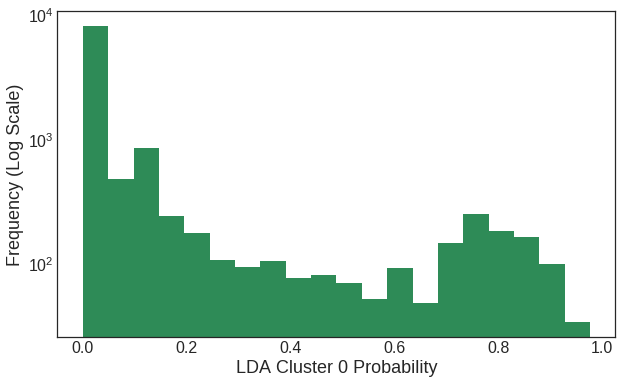

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
# dflda.loc[dflda['made_purchase'] == 1, [0,1,2,3,4,5,6,7]].hist(bins=20, log=True)
ax = dflda.loc[dflda['made_purchase'] == 1, 0].plot('hist', bins=20, log=True, color='seagreen')
# plt.get_fignums()
plt.xlabel('LDA Cluster 0 Probability')
plt.ylabel('Frequency (Log Scale)')
# plt.title('Receiver operating characteristic example')
plt.savefig("../img/LDA_feat_hist.png")